# Метод сеток решения одномерного нестационарного уравнения теплопроводности

In [1]:
import math
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [2]:
x, t = sp.symbols('x t')

### Вывод формул для задачи 2

Рассмотрим уравнение баланса, которое на любом отрезке $[a, b]$, где $0 < a < b < l$, имеет вид:

$$
W(a) - W(b) - \int_a^b q(x)u(x)dx + \int_a^b f(x)dx = 0
$$

$$
W(x) = -k(x)u'(x)
$$

$\int_a^b q(x)u(x)dx$ опустим, так как $q(x) = 0$

Введём:

$$
x_n = nh, n=0,1,2,...,N, Nh = l
$$

А также промежуточные (потоковые) узлы:

$$
x_{n+-0.5} = x_n +- 0.5h
$$

Запишем уравнение баланса на отрезке $[x_{n-0.5}, x_{n+0.5}]$:

$$
W_{n-0.5} - W_{n+0.5} + \int_{x_{n-0.5}}^{x_{n+0.5}} f(x)dx = 0
$$

Найдём $W_{n-0.5}, W_{n+0.5}$. Для этого проинтегрируем $u'(x)=-\frac{W(x)}{k(x)}$ на отрезке $[x_{n-1}, x_n]$:

$$
u_{n-1} - u_n = \int_{x_{n-1}}^{x_n} \frac{W(x)}{k(x)}dx
$$

Тогда при $x_{n-0.5} \leq x \leq x_{n+0.5}$:

$$
W_{n-0.5} \approx -a_n\frac{y_n-y_{n-1}}{h}
$$

$$
a_n = (\frac{1}{h} \int_{x_{n-1}}^{x_n} \frac{dx}{k(x)})^{-1}
$$
А
$$
W_{n+0.5} \approx -b_n\frac{y_{n+1}-y_{n}}{h}
$$

$$
b_n = (\frac{1}{h} \int_{x_{n}}^{x_{n+1}} \frac{dx}{k(x)})^{-1}
$$

Также обозначим:

$$
\varphi_n = \frac{1}{h} \int_{x_{n-0.5}}^{x_{n+0.5}} f(x)dx
$$

#### Получим систему для решения

$$
\frac{1}{h}(b_n\frac{y_{n+1}-y_{n}}{h} -a_n\frac{y_n-y_{n-1}}{h}) = -\varphi_n
$$

И $y_0 = g_1, y_N = g_2$

#### Итоговая формула

$$
\frac{a_n}{h^2} y_{n-1} - \frac{a_n + b_n}{h^2} + \frac{b_n}{h^2} = -\varphi_n
$$

## Задача 2

#### Начальные условия для задачи 2

In [114]:
ua, ub = 1.5, 2.5
ya, yb = 3, -3
k1, k2, k3 = 80, 1, 20
x0, c = ua + (ub - ua) / 2, 100
h = (ub - ua) / 150
k = sp.Piecewise(
    (k1, x < ua + (ub - ua) / 3),
    (k3, ua + 2 * (ub - ua) / 3 <= x),
    (k2, True),
)
source = [(100, ua + (ub - ua) / 2)]

# integral for delta function 
def phi(x, x0, c):
    if abs(x - x0) - h / 2 < 1e-5:
        return c / 2
    elif 2*x - h < 2*x0 < 2*x + h:
        return c
    else:
        return 0

In [115]:
def task2(a, b, ya, yb, h, phi, k_expr, sources):
    l, r = sp.symbols('l r')
    ab = sp.lambdify((l, r), h * (sp.integrate(1/k_expr, (x, l, r)))**(-1))
    n = int((b - a) / h) + 1
    
    matrix = np.zeros(shape=(n, n))
    t = np.zeros(shape=(n, 1))
    xs = np.linspace(a, b, n)
    matrix[0,0] = matrix[-1, -1] = 1
    t[0] = ya
    t[-1] = yb
    
    for i in range(1, n -1):
        matrix[i,i-1] = ab(xs[i-1], xs[i])
        matrix[i, i] = -ab(xs[i-1], xs[i]) - ab(xs[i], xs[i+1])
        matrix[i, i+1] =  ab(xs[i], xs[i+1])
        t[i] = -h * sum(phi(xs[i], x0i, ci) for ci, x0i in sources)
        
    return xs, np.linalg.solve(matrix, t)

#### Решение задачи для одного примера

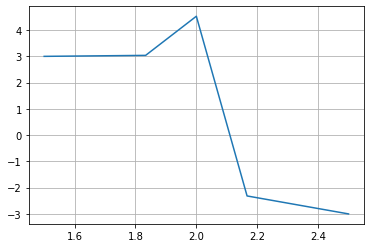

In [116]:
xs, ys = task2(ua, ub, ya, yb, h, phi, k, source)

plt.plot(xs, ys)
plt.grid()
plt.show()

#### Условия для решения задач из методички (для разных плотностей и разных источников)

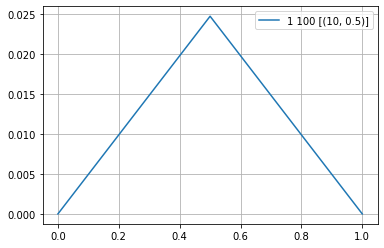

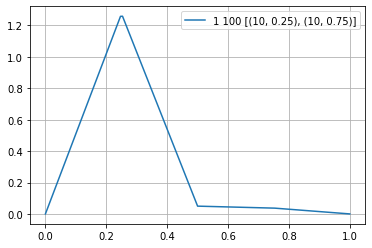

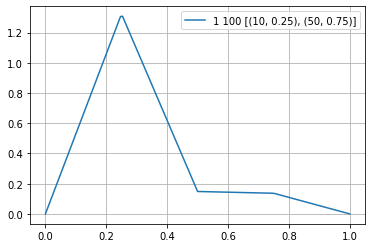

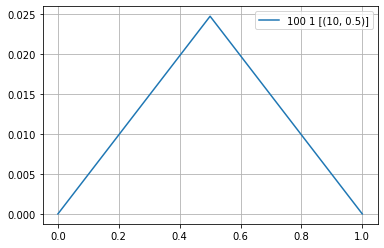

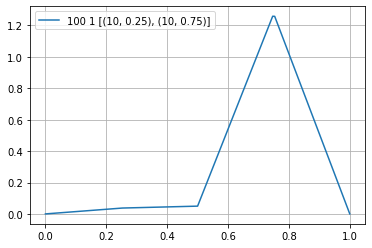

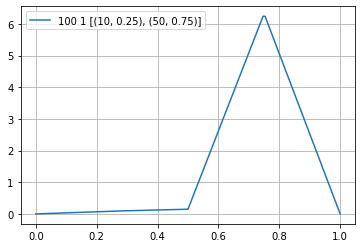

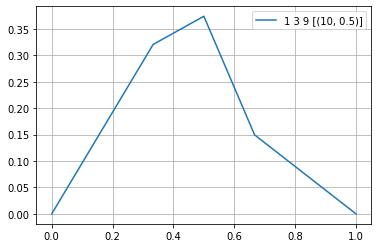

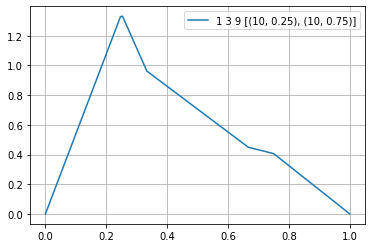

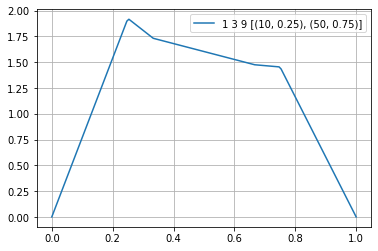

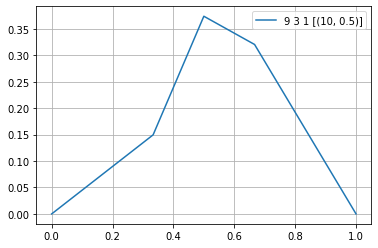

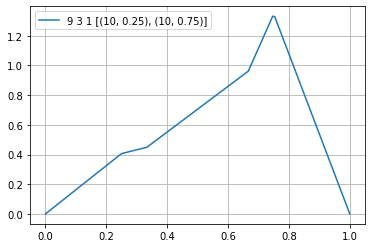

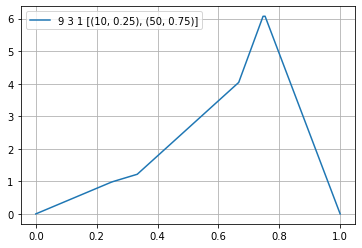

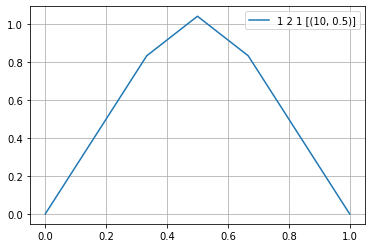

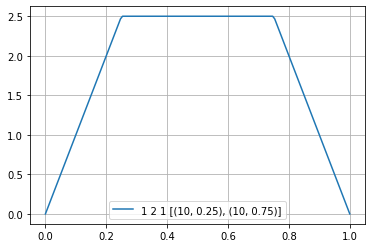

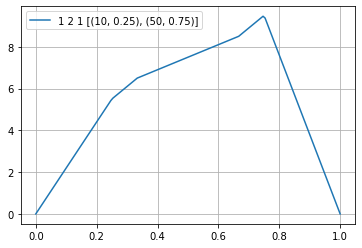

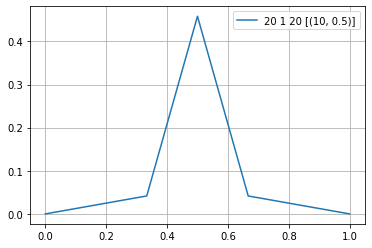

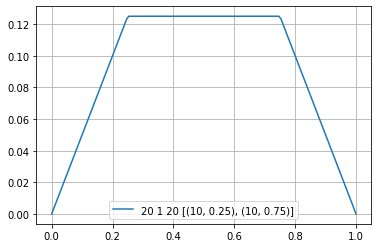

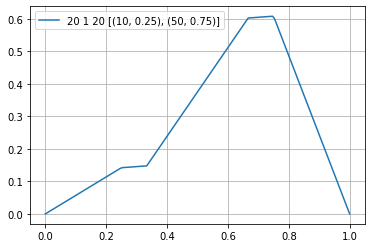

In [117]:
ua, ub = 0, 1
ya, yb = 0, 0
x0, c = ua + (ub - ua) / 2, 100
h = (ub - ua) / 150

sources = [
    [(10, ua + (ub - ua) / 2)],
    [(10, ua + (ub - ua) / 4), (10, ua + 3 * (ub - ua) / 4)],
    [(10, ua + (ub - ua) / 4), (50, ua + 3 * (ub - ua) / 4)],
]

# for two k's
for k1, k2 in [[1, 100], [100, 1]]:
    k = sp.Piecewise(
        (k1, x < ua + (ub - ua) / 2),
        (k2, True),
    )
    for source in sources:
        xs, ys = task2(ua, ub, ya, yb, h, phi, k, source)
        plt.plot(xs, ys, label='{} {} {}'.format(k1, k2, source))
        plt.legend()
        plt.grid()
        plt.show()
    
for k1, k2, k3 in [
    [1, 3, 9],
    [9, 3, 1],
    [1, 2, 1],
    [20, 1, 20]
]:
    k = sp.Piecewise(
        (k1, x < ua + (ub - ua) / 3),
        (k3, ua + 2 * (ub - ua) / 3 <= x),
        (k2, True),
    )
    for source in sources:
        xs, ys = task2(ua, ub, ya, yb, h, phi, k, source)
        plt.plot(xs, ys, label='{} {} {} {}'.format(k1, k2, k3, source))
        plt.legend()
        plt.grid()
        plt.show()

### Вывод используемых формул для задачи 3 и 4



Дано следующее уравнение:

$$
\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2}  + f(x), x \in [a, b], t \in [0, T]
$$

Зададим оператор $L$:

$$
L = \frac{\partial}{\partial t} - \frac{\partial^2}{\partial x^2}
$$

Для аппроксимации оператора $L$ с помощью явной схемы используем следующие точки:

![](https://refdb.ru/images/1449/2896254/4b092928.png)

Обозначим для удобства точки следующим образом:

$$
x_{j,k} = (x, t)
$$

Тогда, обозначив разность 
$$x_{j,k}-x_{j-1, k} = h$$
A
$$x_{j,k+1}-x_{j,k}=\tau$$

Получаем:

$$
x_{j-1, k} = (x - h, t)
$$
$$x_{j+1, k} = (x + h, t)
$$
$$
x_{j, k + 1} = (x, t + \tau)
$$
Используя эти точки можем аппроксимировать функции:

$$
\frac{\partial u}{\partial t} = \frac{u(x, t + \tau) - u(x, t)}{\tau}
$$

$$
\frac{\partial^2 u}{\partial x^2} = \frac{u(x+h, t) - 2u(x, t) + y(x-h, t)}{h^2}
$$

Таким образом результат оператора $Lu$:

$$
Lu = \frac{u(x, t + \tau) - u(x, t)}{\tau} - \frac{u(x+h, t) - 2u(x, t) + y(x-h, t)}{h^2}
$$

Теперь давайте выразим отсюда $u(x, t + \tau)$:

$$
u(x, t + \tau) = u(x, t) + \tau(\frac{u(x + h, t)}{h^2} - 2 \frac{u(x, t)}{h^2} + \frac{u(x-h, t)}{h^2})
$$

### Итого приведя слагаемые:

$$
u(x, t + \tau) = \frac{\tau}{h^2}u(x-h,t) + (1 - \frac{\tau}{h^2})u(x,t) + \frac{\tau}{h^2}u(x+h, t)
$$ 

#### Что в итоге?

Зная значения из нижниго слоя, можно найти значения на верхнем слое

#### Примечание для задачи 3

В задаче 3 есть $\frac{\partial}{\partial x}(k(x)\frac{\partial u}{\partial x})$.

В данном случае аппроксимировать будем следующим образом:

$$
\frac{\partial}{\partial x}(k(x)\frac{\partial u}{\partial x}) = \frac{k(x+\frac{h}{2})u'(x+\frac{h}{2}) - k(x-\frac{h}{2})u'(x-\frac{h}{2})}{\frac{h}{2}}
$$

Теперь аппроксимируя $\frac{\partial u}{\partial x}$ и выражая $u(x, t+\tau)$:

$$
u(x,t+\tau)= \frac{k(x-\frac{h}{2})\tau}{h^2}u(x-h, t) + 
(1 - \frac{(k(x-\frac{h}{2})-k(x+\frac{h}{2}))\tau}{h^2}u(x, t) + \frac{k(x+\frac{h}{2})\tau}{h^2}u(x+h, t)
$$

#### Примечание для задачи 4

В задаче 4 перед $\frac{\partial^2 u}{\partial x^2}$ стоит *const*. 

Несложно заметить, что таким образом при выводе эта константа окажется перед аппроксимацией данной производной и получится следующая формула:

$$
u(x, t + \tau) = \frac{c \cdot \tau}{h^2}u(x-h,t) + (1 - \frac{c \cdot \tau}{h^2})u(x,t) + \frac{c \cdot \tau}{h^2}u(x+h, t), c - const
$$ 

## Задача 3

In [118]:
def task3(x_h, t_h, a, b, k, T, g1, g2, phi, f):
    x_h_step_amount = int((b - a) / x_h) + 1
    t_h_step_amount = int(T / t_h) + 1
    x_hs = np.linspace(a, b, x_h_step_amount)
    t_hs = np.linspace(0, T, t_h_step_amount)
    
    matrix = np.zeros(shape=(t_h_step_amount, x_h_step_amount))
    
    # initial condition
    matrix[0, 1:-1] = np.array([phi(x_hs[i]) for i in range(1, x_h_step_amount-1)])
    
    # bounds condition
    matrix[:, 0] = np.array([g1(x_hs[0], t_hs[i]) for i in range(t_h_step_amount)])
    matrix[:, -1] = np.array([g2(x_hs[-1], t_hs[i]) for i in range(t_h_step_amount)])
    
    for i in range(1, t_h_step_amount):
        for j in range(1, x_h_step_amount-1):
            matrix[i,j] = sum([
                k(x_hs[j] - x_h/2) * t_h / x_h**2 * matrix[i-1, j-1],
                (1 - (k(x_hs[j] - x_h / 2) + k(x_hs[j] + x_h / 2)) * t_h / x_h**2) * matrix[i-1, j],
                k(x_hs[j] + x_h/2) * t_h / x_h**2 * matrix[i-1, j+1],
                t_h * f(x_hs[j], t_hs[i]) * (1 - math.exp(-t_hs[i]))
            ])
            
    # plotting
    ax = plt.axes(projection='3d')
    ax.set_ylabel('$T$ time axis')
    ax.set_xlabel('$X$ spatial axis')
    ax.set_zlabel('$Y$ function value axis')
    

    for i in range(0, t_h_step_amount, 100):
        ax.plot3D(x_hs, np.array([t_hs[i]]*x_h_step_amount), matrix[i,:])    

#### Условия для задачи 3

In [119]:
a, b = 1.5, 2.5
g1 = sp.lambdify((x, t), 3)
g2 = sp.lambdify((x, t), 3)
f = sp.lambdify((x, t), x + x**0.5)
k = sp.lambdify(x, x**(-1/3))
phi = sp.lambdify(x, 12*(x-2)**2)
h_x, h_t = 0.05, 0.001
T = 500 * h_t

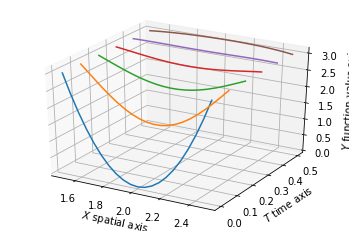

In [120]:
task3(h_x, h_t, a, b, k, T, g1, g2, phi, f)

## Задача 4

In [121]:
def task4(a, b, k, T, phi, g1, g2, f):
    x_h = (b - a) / 50
    x_h_step_amount = int((b - a) / x_h) + 1
    t_h = 0.5 * x_h**2 / k
    t_h_step_amount = int(T / t_h) + 1
    x_hs = np.linspace(a, b, x_h_step_amount)
    t_hs = np.linspace(0, T, t_h_step_amount)
    
    matrix = np.zeros(shape=(t_h_step_amount, x_h_step_amount))
    
    # initial condition
    matrix[0, 1:-1] = np.array([phi(x_hs[i], t_hs[0]) for i in range(1, x_h_step_amount-1)])
    
    # bounds condition
    matrix[:, 0] = np.array([g1(x_hs[0], t_hs[i]) for i in range(t_h_step_amount)])
    matrix[:, -1] = np.array([g2(x_hs[-1], t_hs[i]) for i in range(t_h_step_amount)])
    
    coef = np.array([k * t_h / x_h**2, 1 - 2 * k * t_h / x_h**2, k * t_h / x_h**2])
    
    for i in range(1, t_h_step_amount):
        for j in range(1, x_h_step_amount-1):
            matrix[i][j] = matrix[i-1, j-1:j+2].dot(coef) + t_h * f(x_hs[j], t_hs[i-1])
    
    # plotting
    ax = plt.axes(projection='3d')
    ax.set_ylabel('$T$ time axis')
    ax.set_xlabel('$X$ spatial axis')
    ax.set_zlabel('$Y$ function value axis')
    

    for i in range(0, t_h_step_amount, 10):
        ax.plot3D(x_hs, np.array([t_hs[i]]*x_h_step_amount), matrix[i,:])    

#### Условия для задачи 4

In [122]:
# k = 1
# T = 0.05
# a, b = 0, 1
# phi = sp.lambdify((x, t), 1)
# g1 = sp.lambdify((x, t), sp.exp(t))
# g2 = sp.lambdify((x, t), sp.exp(10*t))
# f = sp.lambdify((x, t), 0)

k = 1
T = 0.5
a, b = 0, 1
phi = sp.lambdify((x, t), 0)
g1 = sp.lambdify((x, t), 0)
g2 = sp.lambdify((x, t), 0)
f = sp.lambdify((x, t), x)

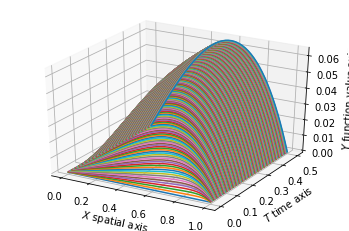

In [123]:
task4(a, b, k, T, phi, g1, g2 , f)